In [1]:

from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 


# --- Configuration ---
DATA_PATH = Path("data/Welding/data.csv")
RESULTS_PATH = Path("../results/")
RANDOM_SEEDS = [42, 1234, 123]
TEST_SIZE = 0.2
CV_FOLDS = 5



In [ ]:

RESULTS_PATH = Path('../results/')
PLOTS_PATH = Path('../plots/')
ENGINEERED_RESULTS_FILE = RESULTS_PATH / 'ex_05_results_engineered_features.csv'
RAW_RESULTS_FILE = RESULTS_PATH / 'ex_05_results_raw_data.csv'

PLOTS_PATH.mkdir(exist_ok=True)

sns.set_theme(style="whitegrid")

In [ ]:
results_eng = pd.read_csv(ENGINEERED_RESULTS_FILE)
results_raw = pd.read_csv(RAW_RESULTS_FILE)

# Add a column to identify the feature set
results_eng['feature_set'] = 'Engineered'
results_raw['feature_set'] = 'Raw'

# Combine into a single dataframe
all_results = pd.concat([results_eng, results_raw], ignore_index=True)

# F1-score is chosen as the primary metric because it balances precision and recall,
sorted_results = all_results.sort_values(by='f1_score_mean', ascending=False)

# Identify the top 3 model-feature set combinations
top_3_models = sorted_results.head(3)

print("--- Full Model Performance Comparison ---")
display(sorted_results)

print("\n--- Top 3 Performing Models ---")
display(top_3_models)



--- Full Model Performance Comparison ---


,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_score_mean,f1_score_std,roc_auc_mean,roc_auc_std,feature_set
2,RandomForest,0.782593,0.002740,0.730234,0.004963,0.815964,0.003988,0.770707,0.001986,0.882698,0.000422,Engineered
6,RandomForest,0.793333,0.006402,0.737709,0.007634,0.793356,0.006395,0.764520,0.007012,0.883599,0.000819,Raw
1,SVC,0.767778,0.000962,0.704940,0.002264,0.827957,0.003122,0.761506,0.000456,0.854190,0.000284,Engineered
3,KNeighborsClassifier,0.766852,0.004456,0.726807,0.004434,0.767990,0.005686,0.746831,0.005009,0.859408,0.000767,Engineered
7,KNeighborsClassifier,0.767857,0.007559,0.706312,0.007077,0.771959,0.011824,0.737675,0.009249,0.855628,0.001603,Raw
5,SVC,0.715952,0.001798,0.610388,0.002223,0.907658,0.006827,0.729904,0.001675,0.839972,0.000381,Raw
4,LogisticRegression,0.755000,0.003113,0.684461,0.004077,0.780405,0.005852,0.729280,0.003375,0.826938,0.001330,Raw
0,LogisticRegression,0.718519,0.001156,0.647700,0.000961,0.814309,0.006120,0.721504,0.002201,0.805932,0.000674,Engineered



--- Top 3 Performing Models ---


,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_score_mean,f1_score_std,roc_auc_mean,roc_auc_std,feature_set
2,RandomForest,0.782593,0.002740,0.730234,0.004963,0.815964,0.003988,0.770707,0.001986,0.882698,0.000422,Engineered
6,RandomForest,0.793333,0.006402,0.737709,0.007634,0.793356,0.006395,0.764520,0.007012,0.883599,0.000819,Raw
1,SVC,0.767778,0.000962,0.704940,0.002264,0.827957,0.003122,0.761506,0.000456,0.854190,0.000284,Engineered


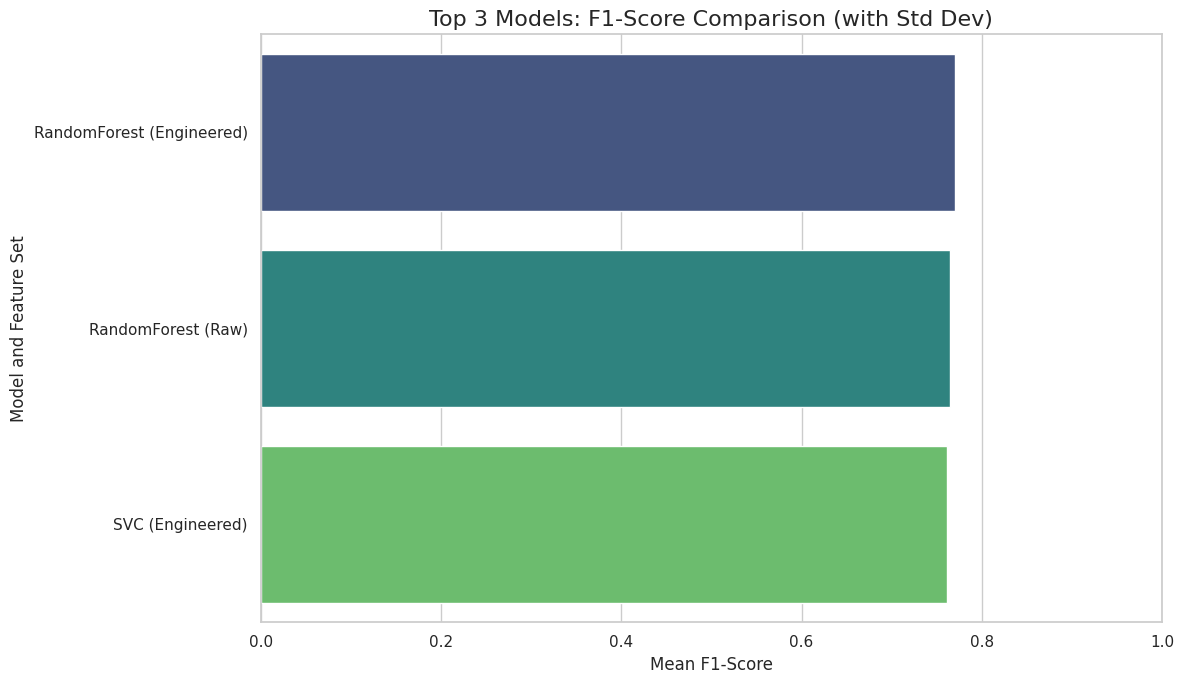

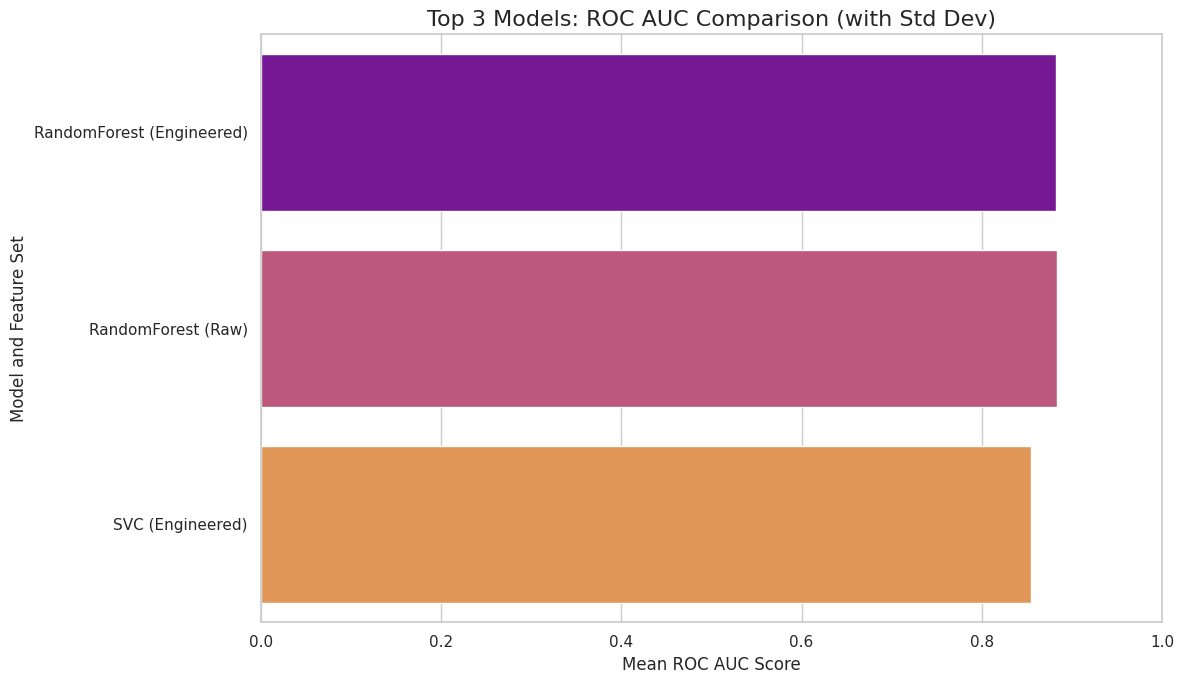

In [ ]:
# Plotting the performance of the top 3 models

plt.figure(figsize=(12, 7))

# Create a combined label for the x-axis
top_3_models['model_label'] = top_3_models['model'] + ' (' + top_3_models['feature_set'] + ')'

# Bar chart for F1-score
sns.barplot(
    x='f1_score_mean',
    y='model_label',
    data=top_3_models
)

plt.title('Top 3 Models: F1-Score Comparison (with Std Dev)', fontsize=16)
plt.xlabel('Mean F1-Score', fontsize=12)
plt.ylabel('Model and Feature Set', fontsize=12)
plt.xlim(0, 1) 
plt.tight_layout()
plt.savefig(PLOTS_PATH / 'f1_score_comparison.png')
plt.show()

# --- Bar chart for ROC AUC ---
plt.figure(figsize=(12, 7))

sns.barplot(
    x='roc_auc_mean',
    y='model_label',
    data=top_3_models
)

plt.title('Top 3 Models: ROC AUC Comparison (with Std Dev)', fontsize=16)
plt.xlabel('Mean ROC AUC Score', fontsize=12)
plt.ylabel('Model and Feature Set', fontsize=12)
plt.xlim(0, 1) 
plt.tight_layout()
plt.savefig(PLOTS_PATH / 'roc_auc_comparison.png')
plt.show()

Generating confusion matrix for the best model: Random Forest (Engineered)


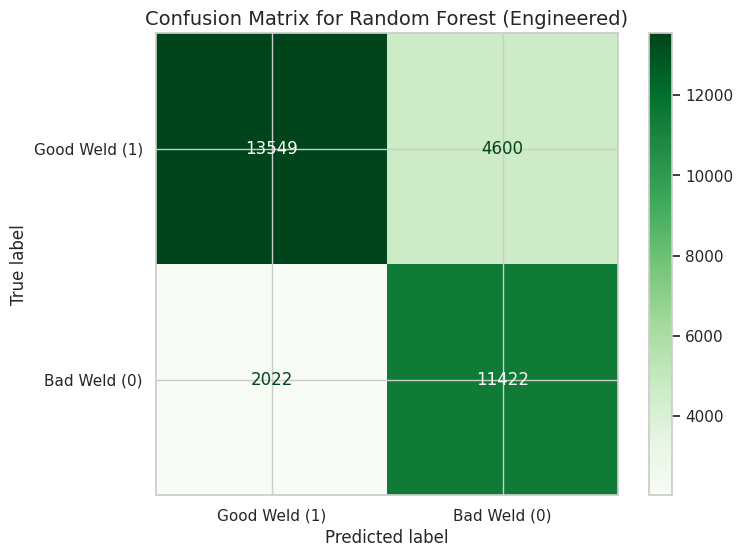

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("Generating confusion matrix for the best model: Random Forest (Engineered)")

data_full, labels_full, _ = get_welding_data(Path("data/Welding/data.csv"))
features_df = extract_features(data_full, labels_full)
X_eng = features_df.drop('label', axis=1)
y_eng = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42
)

#Re-create and train the Random Forest pipeline with its best hyperparameters from Ex 5
best_rf_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42))
])

best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

#Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good Weld (1)', 'Bad Weld (0)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Greens') 
plt.title('Confusion Matrix for Random Forest (Engineered)', fontsize=14)
plt.savefig(PLOTS_PATH / 'confusion_matrix_rf_best_model.png')
plt.show()

Welches Modell war am besten?

Das RandomForest-Modell, trainiert auf den "Engineered Features", war insgesamt am besten.

Beide Balkendiagramme (F1-Score und ROC AUC) zeigen, dass dieses Modell die höchsten Durchschnittswerte erzielt hat, auch wenn der Vorsprung nur gering ist. Es bietet die beste Kombination aus allgemeiner Unterscheidungsfähigkeit (ROC AUC) und einer ausgewogenen Performance (F1-Score).

Unterschied zwischen Engineered vs. Raw Features

Der Leistungsunterschied zwischen den Engineered Features und den rohen Daten war für das RandomForest-Modell gering.

    Warum? Dies deutet darauf hin, dass der RandomForest-Algorithmus stark genug ist, um selbst aus den unverarbeiteten Daten nützliche Muster zu extrahieren. Die "Engineered Features" scheinen diesen Prozess jedoch zu erleichtern und führen zu einer etwas besseren Leistung,

Was die Metriken aussagen

Die Kombination der Grafiken gibt ein vollständiges Bild:

    Die Balkendiagramme (F1 und ROC AUC) zeigen, dass alle drei Top-Modelle eine hohe Leistung erbringen. Die hohen ROC-AUC-Werte (>0.85) bedeuten, dass alle Modelle grundsätzlich gut darin sind, zwischen guten und schlechten Nähten zu unterscheiden.

    Die Konfusionsmatrix des Top-Modells (RandomForest (Engineered)) zeigt das wahre Verhalten:

        Stärke (Recall): Das Modell ist sehr gut darin, fehlerhafte Schweißnähte zu finden. Es hat 11.422 von insgesamt 13.444 schlechten Nähten korrekt identifiziert (ca. 85% Recall).

        Schwäche (Precision): Es produziert dabei eine nennenswerte Anzahl an Fehlalarmen. Von den 16.022 als "schlecht" markierten Nähten waren 4.600 eigentlich gut.

Für die Qualitätssicherung ist dies aber gut: Lieber eine gute Naht wieder zu prüfen, als eine schlechte durchrutschen zu lassen.

Fazit und nächste Schritte

Fazit

Der effektivste Ansatz zur Klassifizierung der Schweißqualität in diesem Experiment ist die Verwendung eines Random Forest Klassifikators in Kombination mit den "Engineered Features". Diese Methode liefert die beste Leistung.

Zukünftige Arbeit

    Precision optimieren: Da der Recall bereits gut ist, sollte der Fokus darauf liegen, die Anzahl der Fehlalarme (False Positives) zu reduzieren. Dies könnte durch besseres Feature Engineering erreicht werden.

    Andere Modelle testen: Modelle wie XGBoost könnten die Ergebnsise verbessern
